# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


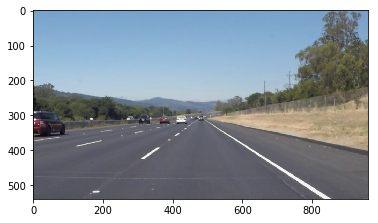

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os


# ==========================================================
# Define functions to process image.
#   Grayscale, Canny Edge Detection and Hough Trnasformation
# ==========================================================

def input_image(img_file):
    """ load an image file into python
        return an image array
    """
    return mpimg.imread(img_file)

def grayscale(img):
    """ apply grayscale transform 
        
        return image with only one channel
    """
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def canny(img,low_threshold,high_threshold):
    """ apply canny edge dector to find edges
       
        return image array
    """
    return cv2.Canny(img,low_threshold,high_threshold)

def region_of_interest(img,vertices):
    """ apply a mask to an image to keep only pixels at interested locations.
        Interested areas are defined by vertices of polygon
        
        The input image is one channel (after grayscale transformation)
        
        vertices is a numpy array of vertices position
        
    """
    # a black image
    mask = np.zeros_like(img) 
    
    # set pixel value for within region of interest locations
    ignore_mask_color = 255 
    
    # filling pixels value inside polygon defined by "vertices"
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    
    # returning  the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

def draw_lines(img,lines,color=[255,0,0],thickness=8):
    """ draw lines """
    
    """extrapolate  
       1. use sign of derivatives to separate left boundary points and right boundary points
       2. for each boundary, leverage linear regression to find boundary lines
    """
    
    left_x = [] # list for x coordinate of left boundary
    left_y = [] # list for y coordiante of left boundary
    right_x = []
    right_y = []
    
    # separate points to left or right boundary
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1)<0:
                left_x.extend([x1,x2])
                left_y.extend([y1,y2])
            elif (y2-y1)/(x2-x1)>0 and (y2-y1)/(x2-x1)<0.8: # horizontal line cannot be lane
                right_x.extend([x1,x2])
                right_y.extend([y1,y2])
            
    # fit regression line and output line parameters
    
    """
    The weights below is created for building a robust lane detector
    
    Both weights are based on the x coordinate of a point from Hough Transform.
    
    For right lane, the larger the x coordinate, the larger the weight is.
    For left lane, the larger the x coordinate, the smaller the weight is.
    """
    weights_right = np.square(right_x)/np.sum(np.square(right_x))
    weights_left = 1.0/np.array(left_x)/np.sum(1.0/np.array(left_x))
    
    # fit weighted linear regression
    z_left = np.polyfit(left_y,left_x,1,w=weights_left) # set y as known to predict x because position of bottom y is always the bottom of image
    z_right = np.polyfit(right_y,right_x,1,w=weights_right)
    f_left = np.poly1d(z_left)
    f_right = np.poly1d(z_right)
    
    # write left boundary
    y_bottom = img.shape[0] # maxmimum y value (the bottom of image)
    
    y_left_top = 325
    x_left_top = int(f_left(y_left_top))
    x_left_bottom = int(f_left(y_bottom)) # predict x coordiate for bottom ending points on the left bound
    cv2.line(img,(x_left_bottom,y_bottom),(x_left_top,y_left_top),color,thickness)
    
    # write right boudary
    y_right_top =325
    x_right_top =int(f_right(y_right_top))
    x_right_bottom = int(f_right(y_bottom)) # predict x coordiate for bottom ending points on the left bound
    cv2.line(img,(x_right_bottom,y_bottom),(x_right_top,y_right_top),color,thickness)
    
    

def hough_lines(img,rho,theta,threshold,min_line_len,max_line_gap):
    """apply Hough transformations to detect lines in images
    
       returns an image with Hough Lines drawn
    """
    
    # cv2.HoughLinesP returns two endingpoints(x,y) of lines.
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    draw_lines(line_img,lines) 
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

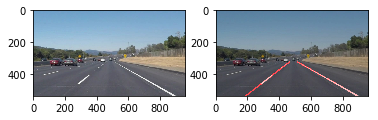

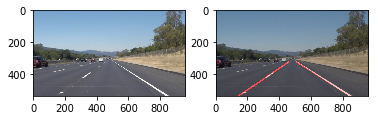

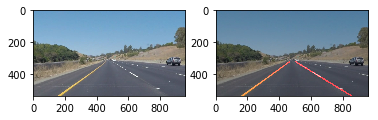

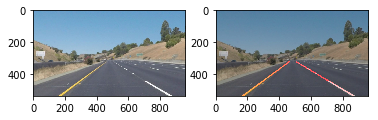

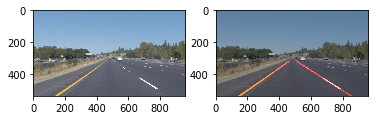

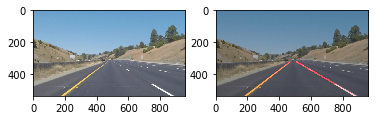

In [6]:
vertices = np.array([[(100,540),(900,540),(475,300),(490,300)]]) # left bottom, right bottom and apex of triangle area
    
""" 
    main part to create the pipeline
"""    
input_directory = "E:/Project/Udacity - Computer Vision/CarND-LaneLines-P1/test_images/"
output_directory = "E:/Project/Udacity - Computer Vision/CarND-LaneLines-P1/test_images_output/"

canny_low = 50
canny_high = 150
hough_rho = 1 # rho step
hough_theta = np.pi/180 # theta step in radians
hough_threshold = 40
min_line_len = 10
max_line_gap = 30


# ================================================
#   Process All Images in Input Directory
# ================================================

for filename in os.listdir(input_directory):
    fig = plt.figure()
    image = input_image(input_directory+filename)
    plt.subplot(121)
    plt.imshow(image)
    image_process = grayscale(image) # transform to grey scale
    image_process = canny(image_process,canny_low,canny_high) # apply canny edge detector
    image_process = region_of_interest(image_process,vertices) # keep only area of interestes
    image_process = hough_lines(image_process,hough_rho,hough_theta,hough_threshold,min_line_len,max_line_gap) # apply hough transformation
    image_process = weighted_img(image_process,image) # combine line image and the original image
    plt.subplot(122)
    plt.imshow(image_process)
    plt.show()
    cv2.imwrite(output_directory+filename,cv2.cvtColor(image_process,cv2.COLOR_RGB2BGR))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    """ input is each frame/image in a clip """
    
    image_process = grayscale(image) # transform to grey scale
    image_process = canny(image_process,canny_low,canny_high) # apply canny edge detector
    image_process = region_of_interest(image_process,vertices) # keep only area of interestes
    image_process = hough_lines(image_process,hough_rho,hough_theta,hough_threshold,min_line_len,max_line_gap) # apply hough transformation
    image_process = weighted_img(image_process,image) # combine line image and the original image

    return image_process

def create_video(raw_video_path,output_path):
    raw_video = VideoFileClip(raw_video_path,audio=False)
    processed_clip = raw_video.fl_image(process_image)
    txt = TextClip("Produced by Wenbo Ma for Lane Detection - X coordinate-based weighted regression", font='Amiri-regular',
	               color='white',fontsize=20)
    txt_col= txt.on_color(size=(processed_clip.w + txt.w,txt.h-5),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)
    w,h = processed_clip.size
    txt_mov = txt_col.set_pos( lambda t: (max(w/30,int(w-0.5*w*t)),40))
    composite_clip = CompositeVideoClip([processed_clip, txt_mov])
    composite_clip.subclip(0,processed_clip.duration).write_videofile(output_path,audio=False)
    raw_video.reader.close() # 
    del raw_video.reader #

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:07<00:00, 30.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.21 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:22<00:00, 30.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.5 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge （Not Complete - Wenbo Ma)

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))